In [10]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

### Exploratory data analysis

In [3]:
#Read train and test datasets
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [4]:
#take a look at the contents of traindf
traindf.head()

,thalach,chol,num
0,150.0,233.0,0
1,108.0,286.0,1
2,187.0,250.0,0
3,178.0,236.0,0
4,160.0,268.0,1


In [5]:
traindf.dtypes

thalach    float64
chol       float64
num          int64
dtype: object

In [6]:
#Convert train and test dataframes of X,y numpy arrays
X_train = traindf.values[:,:-1]
y_train = traindf.values[:,-1]

X_test = testdf.values[:,:-1]
y_test = testdf.values[:,-1]

In [7]:
X_train.shape

(243, 2)

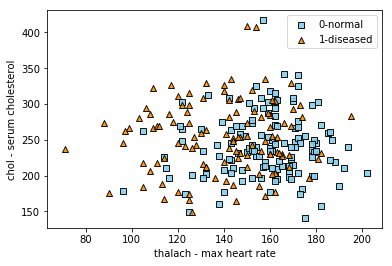

In [74]:
#Visualize train data on a scatter plot
plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1], c='skyblue', marker= 's', edgecolors='k', alpha =0.9, label = '0-normal')
plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1], c='darkorange', marker= '^', edgecolors='k', alpha =0.9, label = '1-diseased')

plt.legend()
plt.xlabel("thalach - max heart rate")
plt.ylabel("chol - serum cholesterol")
plt.show()

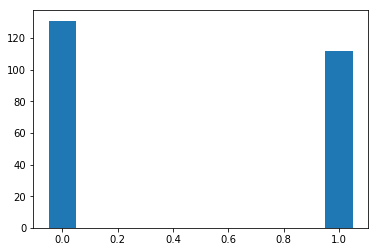

Proportion of diseased cases: 0.46


In [9]:
#Check how balanced the training set is
unique_classes,counts = np.unique(y_train,return_counts = True)
unique_counts = dict(zip(unique_classes,counts))

plt.bar(unique_classes,counts, width = 0.1)
plt.show()

print("Proportion of diseased cases: {}".format(round(unique_counts[1.0]/len(y_train),2)))

EDA shows that the classification boundary is clearly not linear. Therefore, logistic regression or SVM are not appropriate models. Let's try out the following decision tree based algorithms:

   1. A simple decision tree
   2. Bagging
   3. Random forest
   4. Boosting
   
  Since the dataset is fairly balanced, a good model needs to deliver a test accuracy of at least 46%.

### Building models

In [20]:
#Function to get test accuracy
def accuracy(X, y, model):
    return round(accuracy_score(y,model.predict(X)),2)

In [43]:
#plot decision boundary
def plot_regions(X,y,model,ax,title):
    plt.sca(ax)
    plot_decision_regions(X=X, y=y.astype(np.integer), clf=model, legend =2)
    
    plt.title(title)
    plt.xlabel("thalach")
    plt.ylabel("cols")


### 1. Simple decision tree classifier

In [13]:
tree_steps = [('standardizer', StandardScaler()),('tree', DecisionTreeClassifier())]
tree_pipe = Pipeline(tree_steps)

##### Hyperparameter tuning

In [14]:
#define tree params - max depth

tree_params = {"tree__max_depth":list(range(2,11))}

In [15]:
tree = GridSearchCV(tree_pipe,param_grid = tree_params, cv=5)
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
tree.best_params_

{'tree__max_depth': 4}

In [21]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,tree)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,tree))) 

Training accuracy is: 0.75
Testing accuracy is: 0.78


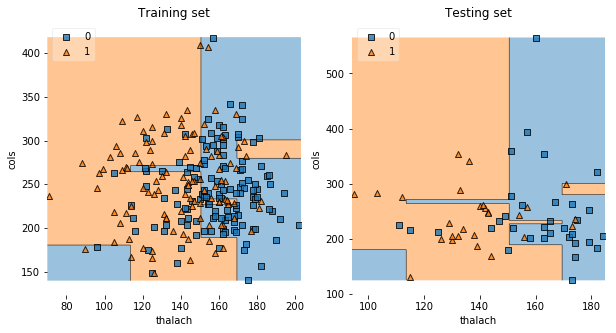

In [44]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, tree,ax[0], "Training set")
plot_regions(X_test,y_test, tree,ax[1], "Testing set")

plt.show()

### 2. Bagging

In [45]:
bag_steps = [('standardizer', StandardScaler()),('bag', BaggingClassifier())]
bag_pipe = Pipeline(bag_steps)

In [46]:
bag_params = {"bag__n_estimators":list(range(2,11))}
bag = GridSearchCV(bag_pipe,param_grid = bag_params, cv=5)
bag.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bag', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bag__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
bag.best_params_

{'bag__n_estimators': 3}

In [48]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,bag)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,bag))) 

Training accuracy is: 0.94
Testing accuracy is: 0.58


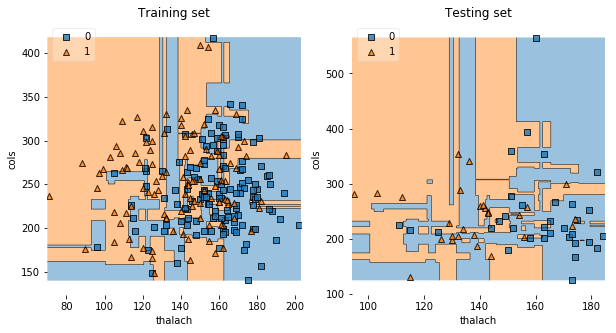

In [49]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, bag,ax[0], "Training set")
plot_regions(X_test,y_test, bag,ax[1], "Testing set")

plt.show()

### 3. Random Forest

In [50]:
rf_steps = [('standardizer', StandardScaler()),('rf', RandomForestClassifier())]
rf_pipe = Pipeline(rf_steps)

In [51]:
rf_params = {"rf__n_estimators":list(range(2,11))}
rf = GridSearchCV(rf_pipe,param_grid = rf_params, cv=5)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [52]:
rf.best_params_

{'rf__n_estimators': 6}

In [53]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,rf)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,rf))) 

Training accuracy is: 0.94
Testing accuracy is: 0.57


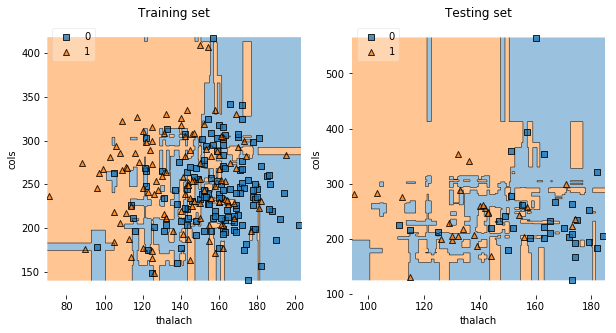

In [54]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, rf,ax[0], "Training set")
plot_regions(X_test,y_test, rf,ax[1], "Testing set")

plt.show()

### 4. Boosting

In [55]:
boost_steps = [('standardizer', StandardScaler()),('boost', AdaBoostClassifier())]
boost_pipe = Pipeline(boost_steps)

In [56]:
boost_params = {"boost__n_estimators":list(range(2,11))}
boost = GridSearchCV(boost_pipe,param_grid = boost_params, cv=5)
boost.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'boost__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [57]:
boost.best_params_

{'boost__n_estimators': 3}

In [58]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,boost)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,boost))) 

Training accuracy is: 0.68
Testing accuracy is: 0.78


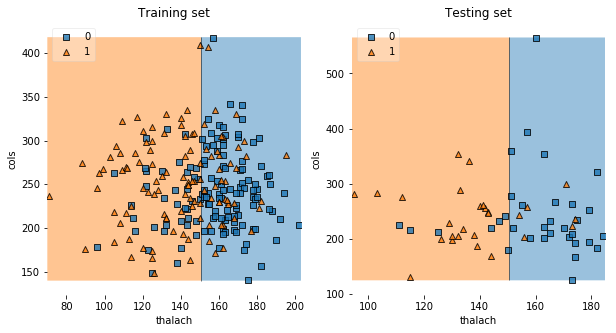

In [59]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, boost,ax[0], "Training set")
plot_regions(X_test,y_test, boost,ax[1], "Testing set")

plt.show()